In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import tensorflow as tf
import numpy as np
import os

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/MSI KATANA/Desktop/practice ML/brain tumour detection system/brain_tumor_dataset',
    image_size=(128, 128),  # Resize to 128x128 to match the example
    batch_size=32,
    shuffle=False  # Keep the data in order to easily split by class
)

# Initialize lists to store images and labels for each class
no_tumor_images = []
yes_tumor_images = []

# Iterate through the dataset and separate the images and labels based on class
for images, labels in dataset:
    images_np = images.numpy()
    labels_np = labels.numpy()

    # Separate images into 'no' and 'yes' classes based on labels
    for i, label in enumerate(labels_np):
        if label == 0:  # Assuming 0 is for 'no' class
            no_tumor_images.append(images_np[i])
        elif label == 1:  # Assuming 1 is for 'yes' class
            yes_tumor_images.append(images_np[i])

# Convert lists to numpy arrays
no_tumor_images = np.array(no_tumor_images)
yes_tumor_images = np.array(yes_tumor_images)

# Create labels for each class
no_tumor_labels = np.zeros(len(no_tumor_images), dtype=int)
yes_tumor_labels = np.ones(len(yes_tumor_images), dtype=int)

# Combine data and labels
X = np.concatenate((no_tumor_images, yes_tumor_images), axis=0)
y = np.concatenate((no_tumor_labels, yes_tumor_labels), axis=0)

# Print shapes to verify
print(f'Total images: {X.shape[0]}')
print(f'No tumor images: {no_tumor_images.shape[0]}')
print(f'Yes tumor images: {yes_tumor_images.shape[0]}')
print(f'Labels shape: {y.shape}')


Found 253 files belonging to 2 classes.
Total images: 253
No tumor images: 98
Yes tumor images: 155
Labels shape: (253,)


In [8]:
# Data Preprocessing
X = X / 255.0
y = to_categorical(y, num_classes=2)


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [11]:
# Use Transfer Learning (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False



58889256/58889256 [==============================] - 15s 0us/step


In [12]:
# Add custom layers
input_layer = Input(shape=(128, 128, 3))
x = base_model(input_layer, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Model training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=25, validation_data=(X_test, y_test))

Epoch 1/25


7/7 [==============================] - 7s 930ms/step - loss: 1.2987 - accuracy: 0.5891 - val_loss: 1.1481 - val_accuracy: 0.4314
Epoch 2/25
7/7 [==============================] - 5s 730ms/step - loss: 1.2059 - accuracy: 0.5990 - val_loss: 0.4148 - val_accuracy: 0.8431
Epoch 3/25
7/7 [==============================] - 5s 744ms/step - loss: 0.8692 - accuracy: 0.6485 - val_loss: 0.5593 - val_accuracy: 0.7843
Epoch 4/25
7/7 [==============================] - 5s 753ms/step - loss: 0.8060 - accuracy: 0.6931 - val_loss: 0.4267 - val_accuracy: 0.8627
Epoch 5/25
7/7 [==============================] - 5s 744ms/step - loss: 0.6342 - accuracy: 0.7079 - val_loss: 0.4261 - val_accuracy: 0.7647
Epoch 6/25
7/7 [==============================] - 5s 784ms/step - loss: 0.5548 - accuracy: 0.7277 - val_loss: 0.4115 - val_accuracy: 0.8824
Epoch 7/25
7/7 [==============================] - 5s 780ms/step - loss: 0.4724 - accuracy: 0.7822 - val_loss: 0.3989 - val_accuracy: 0.8039
Epoch 8/25
7/7 [==

In [14]:
# Model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

2/2 [==============================] - 1s 490ms/step


In [15]:
# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.88      0.90      0.89        31

    accuracy                           0.86        51
   macro avg       0.86      0.85      0.85        51
weighted avg       0.86      0.86      0.86        51

Confusion Matrix:
 [[16  4]
 [ 3 28]]


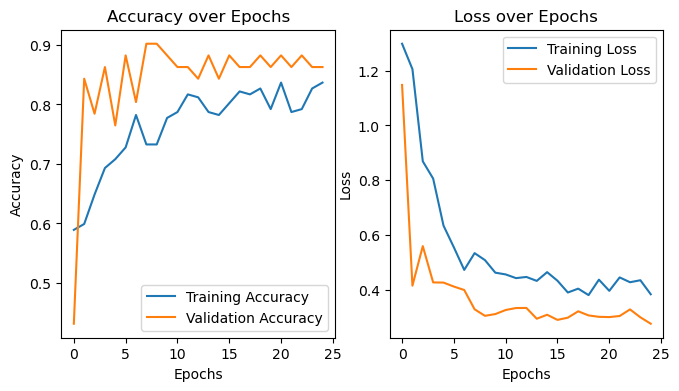

In [16]:
# Plotting training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()